In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from google.colab import drive
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}\n")

Device is: cpu



In [ ]:
data_path = '/content/drive/MyDrive/biomedicine/embedded_data/'

# Hyper- and Controlparameter

In [ ]:
# Controlparameter

LOAD_FROM_DRIVE = False
SAVE_TO_DRIVE = False

In [ ]:
# HYPERPARAMETER

BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

# Custom Dataset & Data Preparation

In [ ]:
# label_map = {
#     'mild/moderate': 0,
#     'severe/critical': 1,
# }

In [ ]:
label_map = {
    'control': 0,
    'mild/moderate': 1,
    'severe/critical': 2,
    'progression': 1,
    'convalescence': 2,
}

In [ ]:
class EmbeddedDataset(Dataset):
    def __init__(self, pkl_file, limit=0):
        self.data = pd.read_pickle(pkl_file)



        unique_labels = pd.unique(self.data['Sample time'])
        cell_types = pd.unique(self.data['celltype'])
        print(f"unique cell types: {cell_types}")
        label_counts = {}
        for label in self.data['Sample time']:
            label_counts[label] = label_counts.get(label, 0) + 1
        print(f"unique labels: {unique_labels}")
        print(f"label counts: {label_counts}")
        print(self.data.head())
        if limit != 0:
            self.downsampling_celltypes(limit)
            print(f"downsampled data: {self.data.head()}")

    def cell_types_list(self):
        return list(pd.unique(self.data['celltype']))
    def distribution_cell_types(self):
        return self.data['celltype'].value_counts()

    def downsampling_celltypes(self, limit):
        cell_types = self.cell_types_list()
        downsampled_data = pd.DataFrame()
        for cell_type in cell_types:
            cell_type_data = self.data[self.data['celltype'] == cell_type]

            if len(cell_type_data) >= limit:
                label_counts = cell_type_data['Sample time'].value_counts()
                min_count = label_counts.min()
                sampled_data = pd.DataFrame()
                for label in label_counts.index:
                    label_data = cell_type_data[cell_type_data['Sample time'] == label]
                    sampled_label_data = label_data.sample(n=min( int(limit/3), min_count), random_state=42)
                    sampled_data = pd.concat([sampled_data, sampled_label_data])

                    downsampled_data = pd.concat([downsampled_data, sampled_label_data])

                #downsampled_data = pd.concat([downsampled_data, cell_type_data])
        self.data = downsampled_data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = torch.tensor(self.data.iloc[idx, 0], dtype=torch.float32)
        label = torch.tensor(label_map.get(self.data.iloc[idx, 1]), dtype=torch.float32)
        cell_type = self.data.iloc[idx, 2]
        return embeddings, label, cell_type

In [ ]:
dataset = EmbeddedDataset(os.path.join(data_path, 'embedded_data_split_severity_celltype_progression_all.pkl'),3000)


unique cell types: ['Mono_c2-CD14-HLA-DPB1' 'T_CD8_c08-IL2RB' 'Mono_c3-CD14-VCAN'
 'T_CD4_c04-ANXA2' 'Mono_c1-CD14-CCL3' 'Mono_c5-CD16' 'T_CD8_c07-TYROBP'
 'Mono_c4-CD14-CD16' 'T_CD4_c07-AHNAK' 'T_CD4_c12-FOXP3' 'B_c01-TCL1A'
 'T_CD4_c01-LEF1' 'T_CD4_c11-GNLY' 'T_CD4_c03-ITGA4' 'T_CD8_c05-ZNF683'
 'B_c03-CD27-AIM2' 'T_CD4_c06-NR4A2' 'T_CD8_c10-MKI67-GZMK'
 'T_CD4_c02-AQP3' 'T_CD8_c04-COTL1' 'T_CD8_c01-LEF1' 'B_c02-MS4A1-CD27'
 'T_CD8_c02-GPR183' 'T_gdT_c14-TRDV2' 'T_CD8_c03-GZMK' 'NK_c01-FCGR3A'
 'Macro_c2-CCL3L1' 'DC_c4-LILRA4' 'T_CD4_c08-GZMK-FOS_h' 'T_CD8_c06-TNF'
 'DC_c2-CD1C' 'T_CD8_c09-SLC4A10' 'T_CD8_c12-MKI67-TYROBP'
 'T_CD4_c09-GZMK-FOS_l' 'NK_c03-MKI67' 'T_CD8_c13-HAVCR2'
 'T_CD4_c13-MKI67-CCL5_l' 'T_CD4_c05-FOS' 'B_c04-SOX5-TNFRSF1B' 'Mega'
 'DC_c1-CLEC9A' 'NK_c02-NCAM1' 'B_c05-MZB1-XBP1' 'T_CD8_c11-MKI67-FOS'
 'T_CD4_c14-MKI67-CCL5_h' 'T_CD4_c10-IFNG' 'B_c06-MKI67' 'Macro_c1-C1QC'
 'Neu_c1-IL1B' 'Macro_c6-VCAN' 'Macro_c5-WDR74' 'Macro_c4-DNAJB1'
 'Epi-Ciliated' 'DC_c3-LAMP3

In [ ]:
dataset.distribution_cell_types()

,count
celltype,
Mono_c2-CD14-HLA-DPB1,3000
T_CD4_c06-NR4A2,3000
T_CD4_c05-FOS,3000
T_CD4_c09-GZMK-FOS_l,3000
T_CD8_c09-SLC4A10,3000
DC_c2-CD1C,3000
T_CD8_c06-TNF,3000
NK_c01-FCGR3A,3000
T_CD8_c03-GZMK,3000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
for (embeddings, labels,_) in train_loader:
    print(type(embeddings[0]))
    print(type(labels[0]))
    print(type(embeddings[0][0]))
    print(type(labels[0].item()))
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'float'>


# Model Architecture


In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=3),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# trainings loop

def train(model, train_loader, num_epocs, optimizer, criterion):
    for epoch in range(num_epocs):
        model.to(device).train()
        running_loss = 0.0
        dataloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epocs}")
        for i, (embeddings, label, _) in enumerate(dataloader):
            embeddings, label = embeddings.to(device), label.to(device).long()
            optimizer.zero_grad()
            output = model(embeddings)
            #criterion = nn.CrossEntropyLoss()
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            dataloader.set_postfix({"loss":running_loss/(i+1)})

In [ ]:
from tqdm import tqdm

# Training Loop
def train(model, train_loader, num_epochs, optimizer, criterion):
    model.to(device)  # Move model to device ONCE
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        dataloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (embeddings, labels, _) in enumerate(dataloader):
            embeddings, labels = embeddings.to(device), labels.to(device).long()  # Ensure labels are long

            optimizer.zero_grad()
            output = model(embeddings)  # Get raw logits

            loss = criterion(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            dataloader.set_postfix({"Loss": running_loss / (i + 1)})  # Show average loss per batch


In [ ]:
# directory paths to google drive for model saving and retrieving

directory_path = 'content/MyDrive/biomedicine/models/classifier'

binary_classifier_model_path = os.path.join(directory_path, 'binary_classifier.pth')

In [ ]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 1/m.weight.shape[1])

In [ ]:
# Initialize the model

classifier_model = Classifier().to(device)

if LOAD_FROM_DRIVE:
    try:
        classifier_model.load_state_dict(torch.load(binary_classifier_model_path, weights_only=True))
        print("Model loaded from drive")
    except Exception as e:
        print(f"Error loading model from drive: {e}")
# else:
#     classifier_model.apply(weights_init)

# set up loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=LEARNING_RATE)

# Training

In [ ]:
# start training loop
if not LOAD_FROM_DRIVE:
    train(
        model=classifier_model,
        train_loader=train_loader,
        num_epochs=NUM_EPOCHS,
        optimizer=optimizer,
        criterion=criterion
    )

Epoch 10/10: 100%|██████████| 626/626 [03:00<00:00,  3.47it/s, Loss=0.328]


In [ ]:
# save to drive

if SAVE_TO_DRIVE:
    try:
        os.makedirs(directory_path)
    except FileExistsError:
        pass

    torch.save(classifier_model.state_dict(), binary_classifier_model_path)
    print("Model saved to drive")

# Evaluation

In [ ]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import numpy as np

def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    cell_type_results = defaultdict(lambda: {"y_true": [], "y_pred": []})  # Store results per cell type

    with torch.no_grad():
        for embeddings, labels, cell_types in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            preds = torch.argmax(outputs, dim=1)  # Convert probabilities to predicted labels

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store results for each cell type
            for i, cell in enumerate(cell_types):
                cell_type_results[cell]["y_true"].append(labels[i].item())
                cell_type_results[cell]["y_pred"].append(preds[i].item())

    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Compute confusion matrix
    cm_state = confusion_matrix(all_labels, all_preds)
    cm_state_normalized = cm_state.astype('float') / cm_state.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_state_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["control", "progression", "convalescence"], yticklabels=["control", "progression", "convalescence"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute metrics per cell type
    cell_type_list, acc_list, f1_list, prec_list, rec_list = [], [], [], [], []
    for cell, values in cell_type_results.items():
        acc = accuracy_score(values["y_true"], values["y_pred"])
        prec = precision_score(values["y_true"], values["y_pred"], average="macro")
        rec = recall_score(values["y_true"], values["y_pred"], average="macro")
        f1 = f1_score(values["y_true"], values["y_pred"], average="macro")

        cell_type_list.append(cell)
        acc_list.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)

    cell_type_results_df = pd.DataFrame({
        "Cell Type": cell_type_list,
        "Accuracy": acc_list,
        "F1-score": f1_list,
        "Precision": prec_list,
        "Recall": rec_list
    })

    f1 = f1_score(all_labels, all_preds, average="macro")

    return accuracy, precision, recall, f1, cell_type_results_df


In [ ]:
import pandas as pd
from collections import Counter

def compare_cell_type_distribution(dataset, train_loader, test_loader):
    # Get total distribution from dataset (assuming it's a DataFrame)
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Total Count"]

    # Initialize counters for train and test sets
    train_counter = Counter()
    test_counter = Counter()

    # Count occurrences of each cell type in training set
    for _, _, cell_types in train_loader:
        train_counter.update(cell_types)

    # Count occurrences of each cell type in test set
    for _, _, cell_types in test_loader:
        test_counter.update(cell_types)

    # Convert counters to Pandas Series
    train_series = pd.Series(train_counter, name="Train Count")
    test_series = pd.Series(test_counter, name="Test Count")

    # Create a DataFrame with all distributions
    df = total_distribution.set_index("Cell Type").join([train_series, test_series]).fillna(0)

    # Convert counts to integers
    df = df.astype(int)

    # Print the table
   # print(df)

    return df


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_correlation(dataset, train_loader, test_loader, model):
    # Step 1: Get dataset distribution
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Train Count"]

    # Step 2: Evaluate model performance per cell type
    _, _, _, _, cell_results = evaluate(model, test_loader)
    """
    # Step 3: Ensure cell_results is properly structured
    if isinstance(cell_results, dict):
        performance_data = []
        for cell_type, metrics in cell_results.items():
            if isinstance(metrics, dict):  # Ensure it's not a string or number
                row = {"Cell Type": cell_type}
                row.update(metrics)  # Add accuracy, F1-score, etc.
                performance_data.append(row)
        performance_df = pd.DataFrame(performance_data)
    else:
        raise ValueError("cell_results is not a valid dictionary.")
    """
    # Step 4: Merge both DataFrames
    merged_df = total_distribution.merge(cell_results, on="Cell Type", how="inner")

    # Step 5: Compute correlation
    correlation_results = {
        "Accuracy": pearsonr(merged_df["Train Count"], merged_df["Accuracy"])[0],
        "F1-score": pearsonr(merged_df["Train Count"], merged_df["F1-score"])[0]
    }

    # Step 6: Visualization
    plt.figure(figsize=(12, 5))

    # Scatter Plot: Frequency vs Accuracy
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["Accuracy"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("Accuracy")
    plt.title(f"Correlation: {correlation_results['Accuracy']:.4f}")

    # Scatter Plot: Frequency vs F1-score
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["F1-score"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("F1-score")
    plt.title(f"Correlation: {correlation_results['F1-score']:.4f}")

    plt.tight_layout()
    plt.show()

    # Print correlation results
    print("Correlation between Cell Type Frequency and Performance:")
    print(f"  Accuracy Correlation: {correlation_results['Accuracy']:.4f}")
    print(f"  F1-score Correlation: {correlation_results['F1-score']:.4f}")

    return merged_df, correlation_results


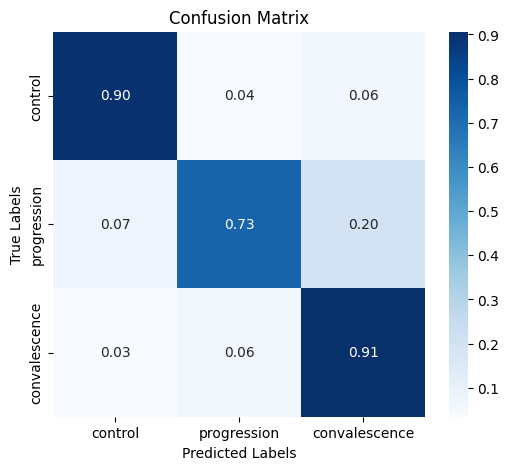

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


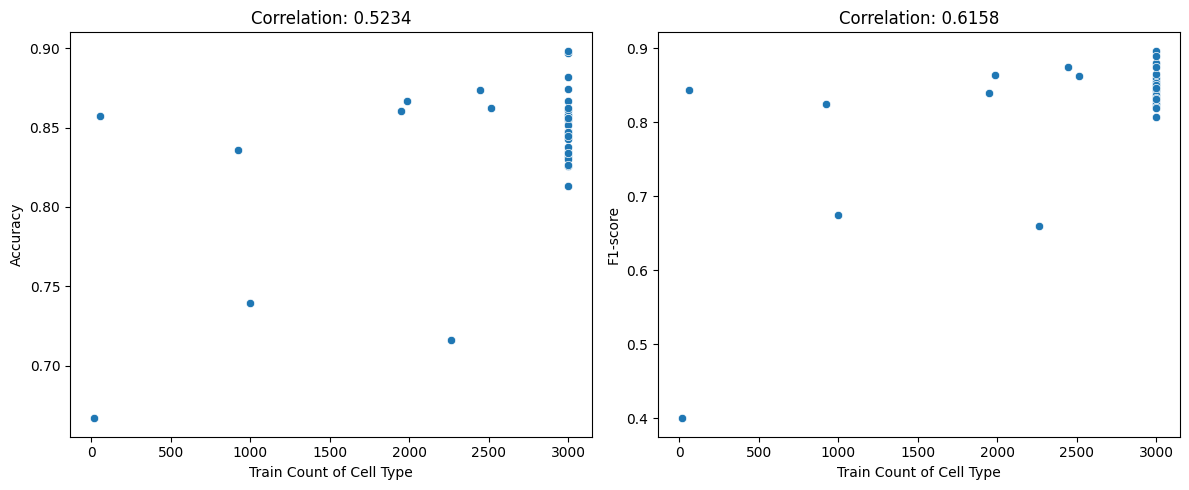

Correlation between Cell Type Frequency and Performance:
  Accuracy Correlation: 0.5234
  F1-score Correlation: 0.6158


In [ ]:
df_analysis, correlation = analyze_correlation(dataset, train_loader, test_loader, classifier_model)

In [ ]:
compare_cell_type_distribution(dataset, train_loader, test_loader)


,Total Count,Train Count,Test Count
Cell Type,,,
Mono_c2-CD14-HLA-DPB1,3000,2393,607
T_CD4_c06-NR4A2,3000,2408,592
T_CD4_c05-FOS,3000,2382,618
T_CD4_c09-GZMK-FOS_l,3000,2380,620
T_CD8_c09-SLC4A10,3000,2398,602
DC_c2-CD1C,3000,2423,577
T_CD8_c06-TNF,3000,2387,613
NK_c01-FCGR3A,3000,2408,592
T_CD8_c03-GZMK,3000,2422,578


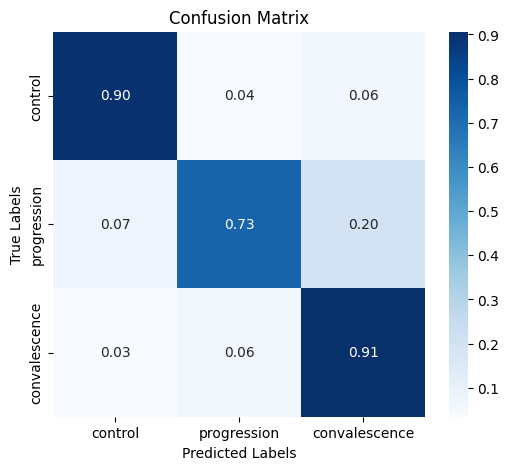

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.8472367829863712,
 0.853168134915956,
 0.8462098935613223,
 0.8458873932765673,
                 Cell Type  Accuracy  F1-score  Precision    Recall
 0         T_CD8_c08-IL2RB  0.842832  0.842897   0.844095  0.844428
 1        T_CD8_c07-TYROBP  0.844741  0.846068   0.856204  0.849060
 2              DC_c2-CD1C  0.882149  0.880489   0.885734  0.881899
 3           NK_c01-FCGR3A  0.834459  0.834245   0.841810  0.835316
 4         T_CD4_c12-FOXP3  0.837925  0.832116   0.851081  0.833606
 5          T_CD8_c03-GZMK  0.847751  0.845915   0.850393  0.847141
 6         B_c03-CD27-AIM2  0.897036  0.896532   0.896601  0.897824
 7    T_CD8_c10-MKI67-GZMK  0.860274  0.839192   0.862066  0.826831
 8        B_c02-MS4A1-CD27  0.874558  0.874444   0.872603  0.880145
 9         T_CD4_c03-ITGA4  0.845528  0.836198   0.860389  0.836630
 10      Mono_c4-CD14-CD16  0.867150  0.863876   0.866897  0.864259
 11         T_CD8_c01-LEF1  0.843333  0.843512   0.856008  0.841166
 12   T_CD4_c09-GZMK-FOS_l  0.861

In [ ]:
evaluate(classifier_model, test_loader)

## Evaluation in detail: